In [1]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree
import numpy as np
from sklearn.decomposition import PCA

In [2]:
# list of audio features that we want to use for analysis
features_list = ['acousticness', 'danceability', 'energy', 
                 'instrumentalness', 'liveness', 'loudness', 
                 'speechiness', 'tempo', 'valence']

### Load data from saved CSVs

In [3]:
# get combined song data from all users except eddie, so we can recommend songs for eddie
df_agg_full = pd.read_csv('aggragated_df.csv')

df_agg_full.head()

,Unnamed: 0,Unnamed: 0.1,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0,0,0.513000,https://api.spotify.com/v1/audio-analysis/1db6...,0.712,199880.0,0.497,1db6ixe9nX6cqt2V1DYZnW,0.000003,4.0,0.3030,-7.943,1.0,0.0639,93.953,4.0,https://api.spotify.com/v1/tracks/1db6ixe9nX6c...,audio_features,spotify:track:1db6ixe9nX6cqt2V1DYZnW,0.457
1,1,1,0.000197,https://api.spotify.com/v1/audio-analysis/786N...,0.588,295187.0,0.825,786NsUYn4GGUf8AOt0SQhP,0.001380,4.0,0.0885,-5.882,1.0,0.0328,129.968,4.0,https://api.spotify.com/v1/tracks/786NsUYn4GGU...,audio_features,spotify:track:786NsUYn4GGUf8AOt0SQhP,0.397
2,2,2,0.010800,https://api.spotify.com/v1/audio-analysis/4qg2...,0.453,257587.0,0.906,4qg2rXtE20scfPhGvG5tqq,0.000000,2.0,0.6570,-3.606,1.0,0.0640,146.960,4.0,https://api.spotify.com/v1/tracks/4qg2rXtE20sc...,audio_features,spotify:track:4qg2rXtE20scfPhGvG5tqq,0.361
3,3,3,0.065900,https://api.spotify.com/v1/audio-analysis/5Clq...,0.470,205442.0,0.696,5ClqcvP4dYDDX6Zv3jPQD1,0.000039,9.0,0.0962,-4.749,1.0,0.1040,169.976,4.0,https://api.spotify.com/v1/tracks/5ClqcvP4dYDD...,audio_features,spotify:track:5ClqcvP4dYDDX6Zv3jPQD1,0.802
4,4,4,0.027100,https://api.spotify.com/v1/audio-analysis/1Mbo...,0.719,157215.0,0.707,1MboFNLuzrmG98WWcoam6B,0.008650,9.0,0.1480,-8.217,1.0,0.2660,197.942,4.0,https://api.spotify.com/v1/tracks/1MboFNLuzrmG...,audio_features,spotify:track:1MboFNLuzrmG98WWcoam6B,0.071


In [4]:
df_agg = df_agg_full.loc[:, features_list].drop_duplicates()

df_agg.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.513000,0.712,0.497,0.000003,0.3030,-7.943,0.0639,93.953,0.457
1,0.000197,0.588,0.825,0.001380,0.0885,-5.882,0.0328,129.968,0.397
2,0.010800,0.453,0.906,0.000000,0.6570,-3.606,0.0640,146.960,0.361
3,0.065900,0.470,0.696,0.000039,0.0962,-4.749,0.1040,169.976,0.802
4,0.027100,0.719,0.707,0.008650,0.1480,-8.217,0.2660,197.942,0.071


In [5]:
# get eddie's song data
df_eddie_full = pd.read_csv('eddie_song_data.csv')

df_eddie_full.head()

,Unnamed: 0,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0,0.192,https://api.spotify.com/v1/audio-analysis/20Mu...,0.741,231964.0,0.645,20MuVazoNMv6xjKPnRFOxG,0.000000,11.0,0.1630,-5.116,0.0,0.0963,149.070,4.0,https://api.spotify.com/v1/tracks/20MuVazoNMv6...,audio_features,spotify:track:20MuVazoNMv6xjKPnRFOxG,0.4880
1,1,0.194,https://api.spotify.com/v1/audio-analysis/4S7Y...,0.598,238307.0,0.252,4S7YHmlWwfwArgd8LfSPud,0.133000,2.0,0.0992,-15.086,1.0,0.0644,120.064,4.0,https://api.spotify.com/v1/tracks/4S7YHmlWwfwA...,audio_features,spotify:track:4S7YHmlWwfwArgd8LfSPud,0.0352
2,2,0.339,https://api.spotify.com/v1/audio-analysis/3F1g...,0.422,225780.0,0.349,3F1gjSkTX9kvxOo6BnlRNd,0.000240,4.0,0.1080,-12.424,0.0,0.3150,57.000,4.0,https://api.spotify.com/v1/tracks/3F1gjSkTX9kv...,audio_features,spotify:track:3F1gjSkTX9kvxOo6BnlRNd,0.1340
3,3,0.634,https://api.spotify.com/v1/audio-analysis/71Aa...,0.450,160160.0,0.300,71AaGUlQ7I5dRgDEQpdnI4,0.000003,7.0,0.1420,-9.530,1.0,0.0477,96.394,4.0,https://api.spotify.com/v1/tracks/71AaGUlQ7I5d...,audio_features,spotify:track:71AaGUlQ7I5dRgDEQpdnI4,0.2070
4,4,0.231,https://api.spotify.com/v1/audio-analysis/4Q34...,0.647,193839.0,0.667,4Q34FP1AT7GEl9oLgNtiWj,0.000000,5.0,0.1330,-5.563,1.0,0.3040,172.080,4.0,https://api.spotify.com/v1/tracks/4Q34FP1AT7GE...,audio_features,spotify:track:4Q34FP1AT7GEl9oLgNtiWj,0.7040


In [6]:
df_eddie = df_eddie_full.loc[:, features_list]

df_eddie.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.192,0.741,0.645,0.000000,0.1630,-5.116,0.0963,149.070,0.4880
1,0.194,0.598,0.252,0.133000,0.0992,-15.086,0.0644,120.064,0.0352
2,0.339,0.422,0.349,0.000240,0.1080,-12.424,0.3150,57.000,0.1340
3,0.634,0.450,0.300,0.000003,0.1420,-9.530,0.0477,96.394,0.2070
4,0.231,0.647,0.667,0.000000,0.1330,-5.563,0.3040,172.080,0.7040


# Apply PCA on both DFs

In [7]:
# Fit transform on df agg. Transform on eddie

# apply principle component analysis to eddie's df and aggregate df
pca = PCA(whiten=True)
agg_prime = pca.fit_transform(df_agg)

agg_prime

array([[-0.76705672, -0.38412263, -0.44664296, ...,  1.11315152,
         0.10644264, -0.72005354],
       [ 0.43868657, -0.69550279,  0.61206556, ..., -0.74489819,
        -0.88546393, -0.93676926],
       [ 1.00825486, -1.11004238,  0.1395863 , ...,  0.93556969,
         0.08870582, -1.11984004],
       ...,
       [-0.39774618, -1.34967589, -0.37817773, ...,  0.07516869,
        -1.90588131, -1.13035191],
       [ 0.1029104 , -0.65558931, -0.67724614, ..., -0.03203128,
        -1.36374928, -1.08411212],
       [ 0.50363694,  0.04960464, -1.19725414, ...,  0.35602184,
        -0.50843834, -0.73538071]])

In [8]:
eddie_prime = pca.transform(df_eddie)

eddie_prime

array([[ 1.07799785, -0.78757567,  0.01776087, ...,  0.73241514,
         0.01490478, -0.31626393],
       [ 0.10241051,  1.18455631,  0.66868706, ...,  0.78611108,
         0.3983179 , -0.45897346],
       [-2.00545889,  0.42055686,  0.06264548, ..., -0.28332496,
        -0.08362978,  2.70024966],
       ...,
       [-1.26060764,  0.56698648,  0.6660888 , ..., -0.27087365,
        -0.2048661 , -0.67489325],
       [-0.87532195, -0.66620567, -1.69762367, ...,  0.82153666,
         0.02249762,  3.28112996],
       [-0.89668714, -1.44902872, -0.26534115, ...,  0.75128461,
         0.30289888,  0.28068498]])

### Choosing a K

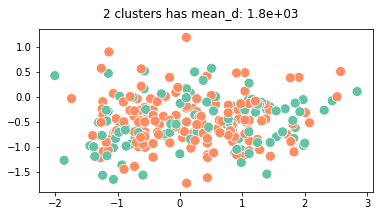

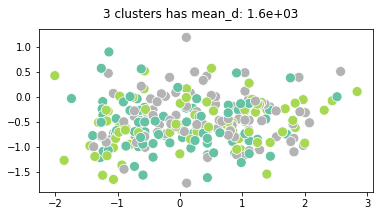

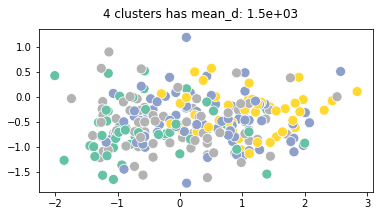

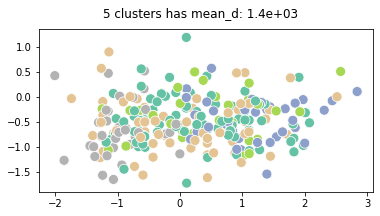

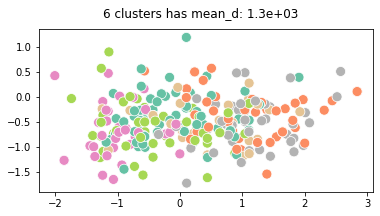

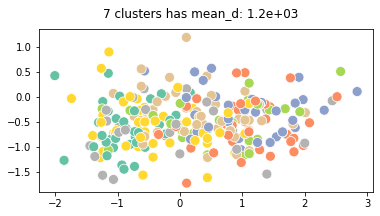

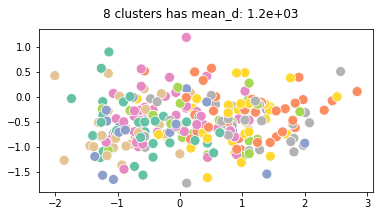

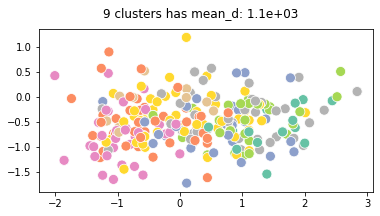

In [9]:
from sklearn.cluster import KMeans
 
x = eddie_prime

mean_d_dict = dict()
for n_clusters in range(2, 10):

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(x)
    y = kmeans.predict(x)

    plt.figure()
    sns.scatterplot(x=x[:, 0], y=x[:, 1], s=100, hue=y, palette='Set2')
    
    # compute & store mean distance
    mean_d = -kmeans.score(x)
    mean_d_dict[n_clusters] = mean_d
    
    plt.suptitle(f'{n_clusters} clusters has mean_d: {mean_d:.1e}')
    
    plt.gca().get_legend().remove()
    plt.gcf().set_size_inches(6, 3)

Note that our data has 9 dimensions, making it difficult to represent visually above. We'll quantify separation later.

In [10]:
mean_d_dict

{2: 1780.884352661536,
 3: 1603.258360778769,
 4: 1460.722922374618,
 5: 1356.5259260759594,
 6: 1278.7476902701187,
 7: 1220.2612093473729,
 8: 1170.0934502327802,
 9: 1119.6444294844664}

Text(0, 0.5, 'mean dist^2 to centroid')

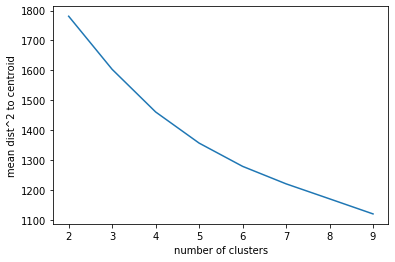

In [11]:
plt.plot(list(mean_d_dict.keys()), list(mean_d_dict.values()))
plt.xlabel('number of clusters')
plt.ylabel('mean dist^2 to centroid')

5 clusters is our best number based on the above plot, so we used 5 clusters below.

In [12]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(x)
y = kmeans.predict(x)

In [13]:
# these centroids represent the clustered data from eddie_df
centroids = kmeans.cluster_centers_

centroids

array([[ 0.339101  , -0.4465599 ,  0.20258149, -0.26983642, -1.12945647,
        -1.03106017,  0.97029071, -0.42838579, -0.10704062],
       [-0.16242565, -0.612816  , -0.06065886, -0.29186632,  0.7355431 ,
        -0.64331946,  0.35898097,  0.00497245, -0.00273076],
       [ 0.52159281, -0.5049504 ,  0.74553018, -0.27999523, -0.29736057,
         1.27042612,  1.53035996,  0.38909206,  0.2586405 ],
       [ 1.18084888, -0.34908654,  0.33965695, -0.40144815, -0.08358982,
        -0.35439317,  1.16837138, -0.49308618,  2.36989688],
       [-0.93314771, -0.71343968,  0.03640383, -0.24645489, -0.36103856,
        -0.1985984 ,  0.52666018, -0.83936717,  2.19688552]])

## Cluster visualization

In [14]:
# code modified from https://stackoverflow.com/questions/32008994/seaborn-scatterplot-matrix-adding-extra-points-with-custom-styles

# add the centroids to a dataframe as rows
centroids_df = pd.DataFrame(centroids, columns=features_list)
# add a column labeling the centroids
centroids_df['cluster'] = 'centroid'

centroids_df

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,cluster
0,0.339101,-0.446560,0.202581,-0.269836,-1.129456,-1.031060,0.970291,-0.428386,-0.107041,centroid
1,-0.162426,-0.612816,-0.060659,-0.291866,0.735543,-0.643319,0.358981,0.004972,-0.002731,centroid
2,0.521593,-0.504950,0.745530,-0.279995,-0.297361,1.270426,1.530360,0.389092,0.258640,centroid
3,1.180849,-0.349087,0.339657,-0.401448,-0.083590,-0.354393,1.168371,-0.493086,2.369897,centroid
4,-0.933148,-0.713440,0.036404,-0.246455,-0.361039,-0.198598,0.526660,-0.839367,2.196886,centroid


In [15]:
# extend eddie's dataframe to include labels
df_eddie_ext = pd.DataFrame(eddie_prime, columns=features_list)

# combine predictions and eddie into one dataframe
df_eddie_ext['cluster'] = y

df_eddie_ext

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,cluster
0,1.077998,-0.787576,0.017761,-0.163018,-0.131721,-0.745261,0.732415,0.014905,-0.316264,0
1,0.102411,1.184556,0.668687,-0.636691,-2.192724,-1.195034,0.786111,0.398318,-0.458973,0
2,-2.005459,0.420557,0.062645,-0.799864,-1.673413,-0.229678,-0.283325,-0.083630,2.700250,4
3,-0.686285,-0.043189,-1.312524,-0.638141,-0.564152,-0.282734,-0.174446,0.961443,0.008614,1
4,1.847381,-0.617975,0.302380,-0.250116,0.586193,-0.355588,0.110032,-0.002725,2.304540,3
...,...,...,...,...,...,...,...,...,...,...
288,0.439406,-0.832389,-0.429787,-0.325486,1.660304,-0.840318,-0.309242,1.369540,0.377395,1
289,1.105613,-0.702896,-0.512613,-0.261547,1.292774,0.096393,-0.173360,-0.756666,1.653210,3
290,-1.260608,0.566986,0.666089,-0.974854,0.559171,-0.405272,-0.270874,-0.204866,-0.674893,1
291,-0.875322,-0.666206,-1.697624,-0.600134,1.962943,0.253894,0.821537,0.022498,3.281130,4


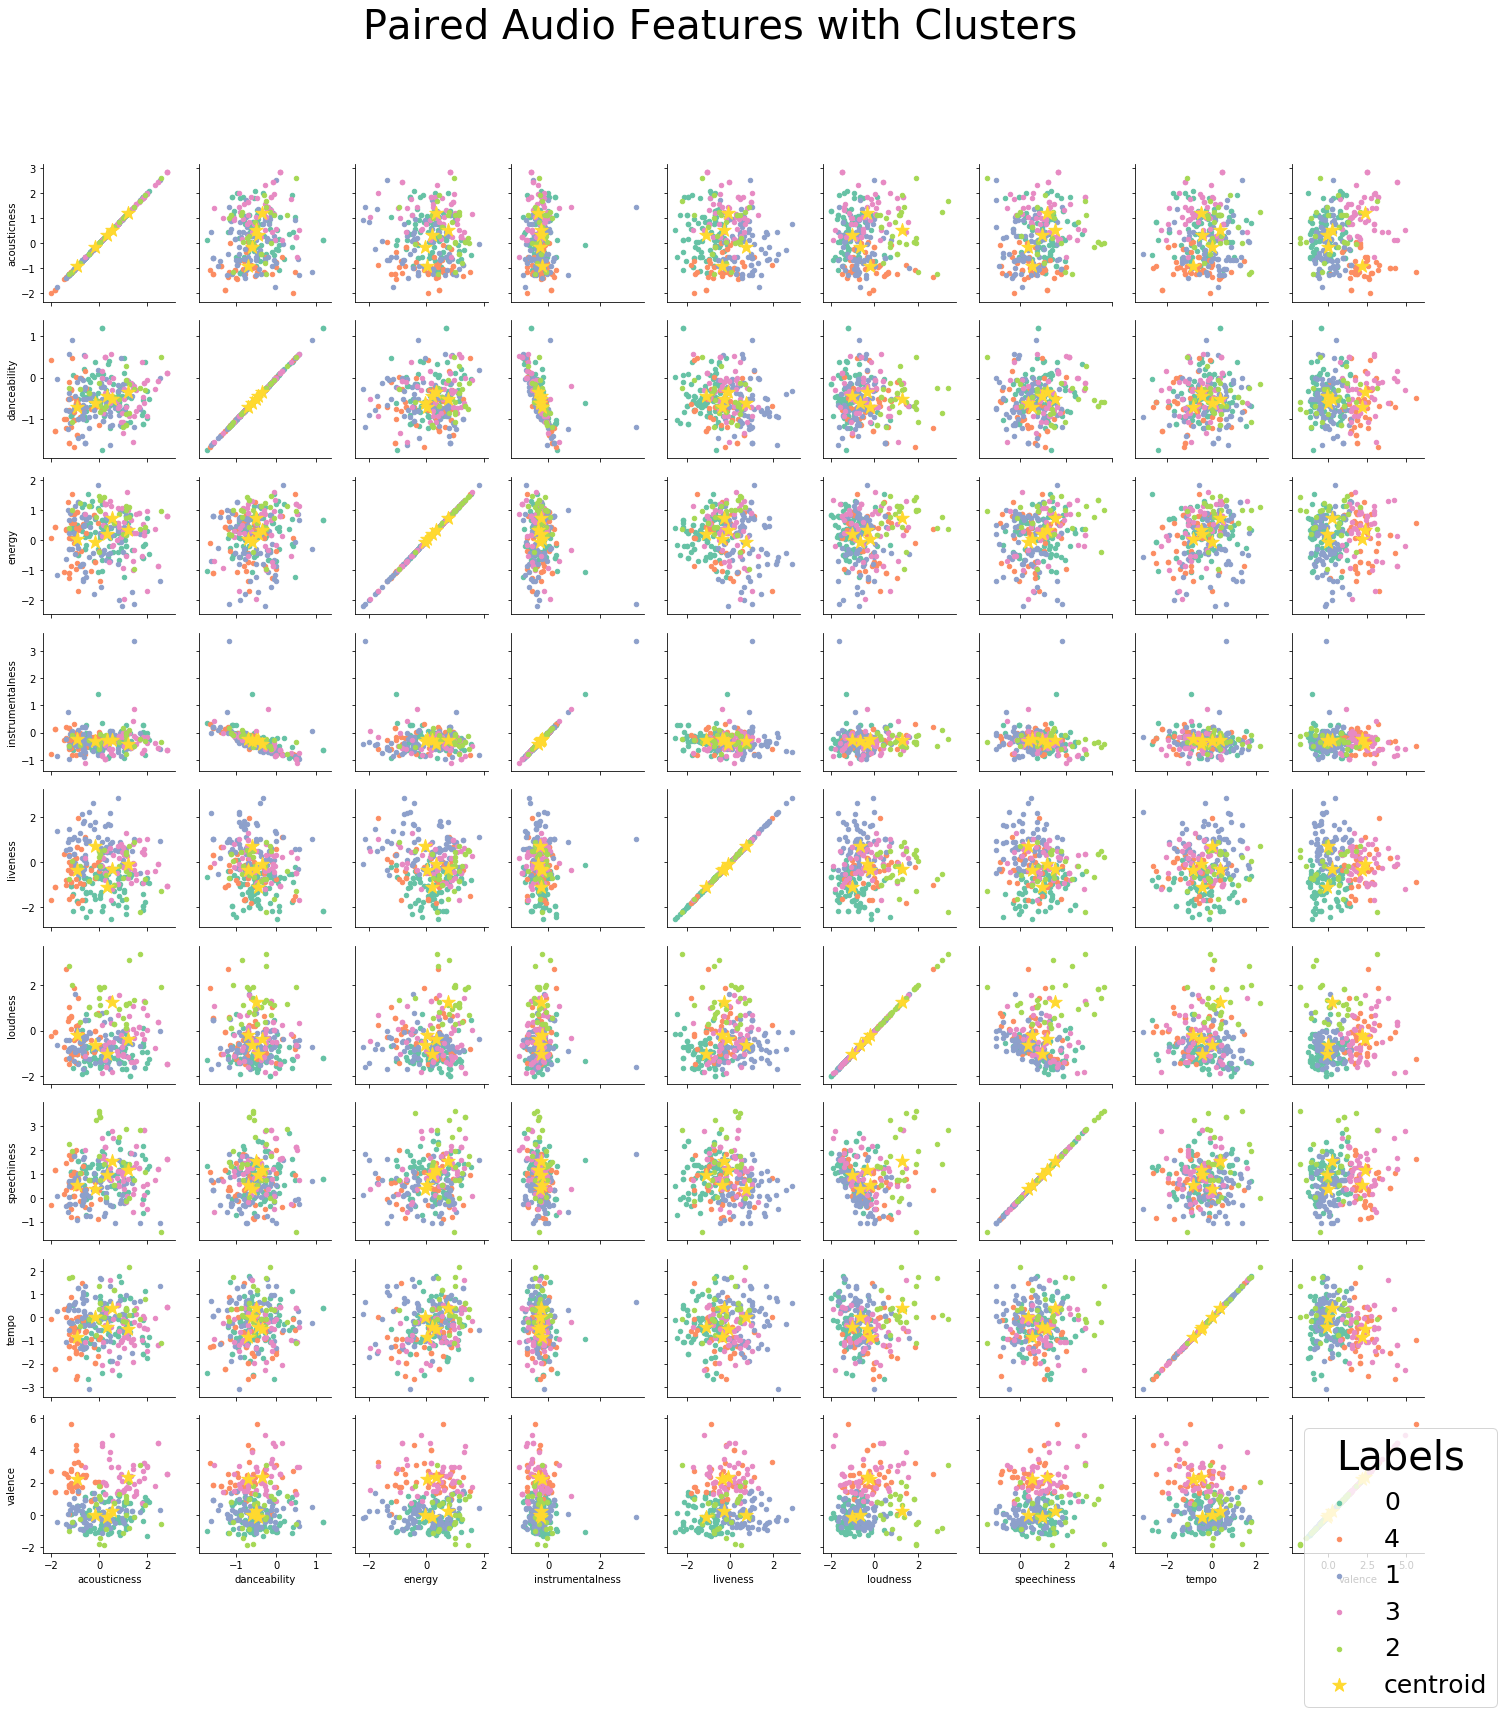

In [16]:
# combine centroids and eddie into one dataframe
eddie_centrs_df = pd.concat([df_eddie_ext, centroids_df], ignore_index=True)

centr_vis = sns.PairGrid(eddie_centrs_df, hue='cluster',
                         palette='Set2',
                         hue_kws={'s': [20, 20, 20, 20, 20, 200],
                                 'marker': ['o', 'o', 'o', 'o', 'o', '*']})

centr_vis.map(plt.scatter, linewidth=1)
plt.legend(title='Labels', fontsize='25', title_fontsize='40')
centr_vis.fig.suptitle('Paired Audio Features with Clusters', y=1.1, fontsize = 40)
centr_vis.fig.set_size_inches(20, 20)

In [17]:
centr_vis.savefig('cluster_pairgrid.pdf')

The centroids we got are a coarse representation of user preference.

Now, we loop over the centroids and get k nearest for each. We treat the centroids as "query embeddings" in an embedding space of possible recommendations, and recommend the items that are closest to each query embedding. 

In [18]:
import collections

# init a KD Tree that we can query to find the nearest neighbors 
kdt = KDTree(agg_prime, leaf_size=30, metric='euclidean')

rec_indices = list()

# for each centroid, get k nearest
for centroid in centroids:
    
    # reshape centroid
    centroid = centroid.reshape(-1,1)

    # query KDT to find indexes of nearest neighbors to our centroid
    nearest_list = kdt.query(centroid.T, k=10, return_distance=False)
    
    # add items that haven't already been recommended
    
    for idx in nearest_list.flatten():
        rec_indices.append(idx)

len(rec_indices)

50

Now we can see the 10 candidates closest to each query embedding. It doesn't look like much, so we'll get the corresponding songs.

In [19]:
# get the rows from df_agg corresponding to the indices we found
df_nearest = df_agg_full.iloc[rec_indices, :]

df_nearest

,Unnamed: 0,Unnamed: 0.1,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
624,624,624,0.762000,https://api.spotify.com/v1/audio-analysis/3BXE...,0.530,224785.0,0.3960,3BXErKHaGALZhSjwnyxMaB,0.000000,0.0,0.1240,-5.544,1.0,0.0294,129.901,4.0,https://api.spotify.com/v1/tracks/3BXErKHaGALZ...,audio_features,spotify:track:3BXErKHaGALZhSjwnyxMaB,0.6510
1269,232,232,0.131000,https://api.spotify.com/v1/audio-analysis/3nvR...,0.783,345528.0,0.6930,3nvREfeASA91U3atMsVO3H,0.881000,10.0,0.0171,-7.764,0.0,0.0972,108.022,4.0,https://api.spotify.com/v1/tracks/3nvREfeASA91...,audio_features,spotify:track:3nvREfeASA91U3atMsVO3H,0.8540
1021,184,184,0.234000,https://api.spotify.com/v1/audio-analysis/2Jh3...,0.712,201920.0,0.5150,2Jh3UqxnHJMyzMzku4uOtE,0.000000,10.0,0.2050,-6.004,0.0,0.0857,160.000,4.0,https://api.spotify.com/v1/tracks/2Jh3UqxnHJMy...,audio_features,spotify:track:2Jh3UqxnHJMyzMzku4uOtE,0.5630
1075,38,38,0.652000,https://api.spotify.com/v1/audio-analysis/6f6p...,0.282,345887.0,0.3720,6f6pEjgfTtuRROmJ4a7Gf3,0.416000,5.0,0.0754,-9.771,1.0,0.0316,105.215,3.0,https://api.spotify.com/v1/tracks/6f6pEjgfTtuR...,audio_features,spotify:track:6f6pEjgfTtuRROmJ4a7Gf3,0.0552
839,2,2,0.000659,https://api.spotify.com/v1/audio-analysis/0HJR...,0.290,493400.0,0.8270,0HJRAM7Gt9jXskuXjZeFX3,0.000003,8.0,0.3010,-3.451,1.0,0.0362,167.086,4.0,https://api.spotify.com/v1/tracks/0HJRAM7Gt9jX...,audio_features,spotify:track:0HJRAM7Gt9jXskuXjZeFX3,0.4500
871,34,34,0.240000,https://api.spotify.com/v1/audio-analysis/7Hk6...,0.414,206040.0,0.6640,7Hk6vSplBGJ6zK9GcGgeIa,0.065600,0.0,0.2880,-6.870,1.0,0.0379,183.670,4.0,https://api.spotify.com/v1/tracks/7Hk6vSplBGJ6...,audio_features,spotify:track:7Hk6vSplBGJ6zK9GcGgeIa,0.8630
1024,187,187,0.054600,https://api.spotify.com/v1/audio-analysis/3eek...,0.598,175721.0,0.4270,3eekarcy7kvN4yt5ZFzltW,0.000006,7.0,0.2100,-8.764,0.0,0.0317,76.469,4.0,https://api.spotify.com/v1/tracks/3eekarcy7kvN...,audio_features,spotify:track:3eekarcy7kvN4yt5ZFzltW,0.0605
386,386,386,0.178000,https://api.spotify.com/v1/audio-analysis/3Qeq...,0.564,228651.0,0.6560,3Qeq4pMfjYwXOgJN6meOpG,0.000000,1.0,0.1920,-8.419,0.0,0.0564,101.213,4.0,https://api.spotify.com/v1/tracks/3Qeq4pMfjYwX...,audio_features,spotify:track:3Qeq4pMfjYwXOgJN6meOpG,0.6760
356,356,356,0.691000,https://api.spotify.com/v1/audio-analysis/3lWE...,0.616,256148.0,0.3830,3lWEqatHZ2wIE2RCOmQkF8,0.000002,10.0,0.0875,-10.791,1.0,0.0911,104.451,4.0,https://api.spotify.com/v1/tracks/3lWEqatHZ2wI...,audio_features,spotify:track:3lWEqatHZ2wIE2RCOmQkF8,0.6000
1683,646,646,0.825000,https://api.spotify.com/v1/audio-analysis/7ixi...,0.722,196507.0,0.6050,7ixiCZEHWHc8FxaQXQh2P4,0.017800,5.0,0.2480,-6.070,1.0,0.1530,165.998,4.0,https://api.spotify.com/v1/tracks/7ixiCZEHWHc8...,audio_features,spotify:track:7ixiCZEHWHc8FxaQXQh2P4,0.7090


### Understanding the Recommendations

In [20]:
# get list of track IDs from the dataframe
track_list = df_nearest['id'].values

# join the tracks IDs together with commas
tracks_str = ','.join(track_list)

# generate endpoint string
tracks_endpoint = f'https://api.spotify.com/v1/tracks?ids={tracks_str}'

In [21]:
# request from API
import requests

# NOTE: tokens only last 1 hour. we need a new access token every time we want to run this
access_token = 'BQBspr8U0WrVjL-rSWf7zGQBDTfKq7hkHpA1d9FWaB1j5sCR0n5VhbdaZf9zdAkEXTFL53rEnlwU5nuFzvwi5zvoUBLu_qBLsOa17JK__NmccXiOc_rO5mkrP_GcDfUTj3zSgM8Os2QWVotsnpn-6p5C'

headers = {
    'Authorization': f'Bearer {access_token}',
    'Content-Type': 'application/json',
    'Accept': 'application/json'
}

req_data = requests.get(tracks_endpoint, headers=headers)

In [22]:
req_json = req_data.json()

def get_recommendations(req_json):
    """parses response data from Spotify API to get artist names, track names, and URLs
    Args:
        req_json (json): json response data from Spotify API for a set of tracks
    Returns:
        df_recommendations (pd.DataFrame): dataframe of artist names, track names, and URLs 
                                           corresponding to these tracks
    """
    # init a dataframe to hold desired attributes for output
    df_recommendations = pd.DataFrame(columns=['artist name', 'track name', 'URL'])

    # for each track in our response data
    for track in req_json['tracks']:

        # init a series to hold desired attributes for output
        track_series = pd.Series()

        # get artist name
        track_series['artist name'] = track['artists'][0]['name']
        # get track name
        track_series['track name'] = track['name']
        # get track URL
        track_series['URL'] = track['external_urls']['spotify']

        # append our series to the dataframe
        df_recommendations = df_recommendations.append(track_series, ignore_index=True)
        
    return df_recommendations

get_recommendations(req_json)

,artist name,track name,URL
0,The Icarus Account,Favorite Girl,https://open.spotify.com/track/3BXErKHaGALZhSj...
1,Snarky Puppy,Bad Kids To The Back,https://open.spotify.com/track/3nvREfeASA91U3a...
2,Juice WRLD,Feeling,https://open.spotify.com/track/2Jh3UqxnHJMyzMz...
3,Radiohead,The Numbers,https://open.spotify.com/track/6f6pEjgfTtuRROm...
4,Green Day,Holiday / Boulevard of Broken Dreams,https://open.spotify.com/track/0HJRAM7Gt9jXsku...
5,Arctic Monkeys,One for the Road,https://open.spotify.com/track/7Hk6vSplBGJ6zK9...
6,Travis Scott,HIGHEST IN THE ROOM,https://open.spotify.com/track/3eekarcy7kvN4yt...
7,Lawrence,Do You Want to Do Nothing with Me? - Audiotree...,https://open.spotify.com/track/3Qeq4pMfjYwXOgJ...
8,Fat Night,Question,https://open.spotify.com/track/3lWEqatHZ2wIE2R...
9,Sister Nancy,Bam Bam,https://open.spotify.com/track/7ixiCZEHWHc8Fxa...


## Are these recommendations good?
It's difficult to quantify how good song recommendations are, so we'll give a few examples of using specific songs as the query and showing the recommendations that are made for it.

```python
# the endpoint for audio features of Boredom by Tyler the Creator. we found the ID by going
# in Spotify, clicking the 3 dots next to this song, Share -> Copy Spotify URI
# here's the result: spotify:track:5WNYg3usc6H8N3MBEp4zVk
boredom_endpoint = f'https://api.spotify.com/v1/audio-features/5WNYg3usc6H8N3MBEp4zVk'

req_boredom = requests.get(boredom_endpoint, headers=headers)

req_boredom.json()
```
{'danceability': 0.559,
 'energy': 0.578,
 'key': 8,
 'loudness': -9.54,
 'mode': 1,
 'speechiness': 0.151,
 'acousticness': 0.79,
 'instrumentalness': 0.000522,
 'liveness': 0.324,
 'valence': 0.239,
 'tempo': 79.938,
 'type': 'audio_features',
 'id': '5WNYg3usc6H8N3MBEp4zVk',
 'uri': 'spotify:track:5WNYg3usc6H8N3MBEp4zVk',
 'track_href': 'https://api.spotify.com/v1/tracks/5WNYg3usc6H8N3MBEp4zVk',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5WNYg3usc6H8N3MBEp4zVk',
 'duration_ms': 320720,
 'time_signature': 4}
 
```python
boredom_series = pd.Series(req_boredom.json())

# get the post-PCA values for this song from our data
df_agg_full.index[df_agg_full['id'] == '5WNYg3usc6H8N3MBEp4zVk']
# the song is at index 1189, so we can grab it from the post-PCA matrix
agg_prime[1189]

```
array([-1.22901312, -0.04273093, -1.35509872,  0.4443527 , -0.13558097,
        1.09551314,  0.42465108,  1.58818226, -0.31821814])

In [23]:
boredom_pca = np.array([-1.22901312, -0.04273093, -1.35509872, 0.4443527 , -0.13558097, 1.09551314, 0.42465108, 1.58818226, -0.31821814])

# use this song as a query to our KDTree, same way we did for the centroids

nearest_boredom = kdt.query(boredom_pca.reshape(-1,1).T, k=10, return_distance=False)

nearest_boredom

array([[ 594,  647,  429, 1535,  423,  929,  280, 2103, 1638,  920]])

In [24]:
# get the rows from df_agg corresponding to the indices we found
df_nearest = df_agg_full.iloc[nearest_boredom.flatten(), :]

df_nearest

,Unnamed: 0,Unnamed: 0.1,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
594,594,594,0.585000,https://api.spotify.com/v1/audio-analysis/3gri...,0.782,179310.0,0.422,3griMd2FSimhnvHWOveakD,0.000087,5.0,0.1190,-6.464,0.0,0.3110,87.091,4.0,https://api.spotify.com/v1/tracks/3griMd2FSimh...,audio_features,spotify:track:3griMd2FSimhnvHWOveakD,0.509
647,647,647,0.715000,https://api.spotify.com/v1/audio-analysis/2bbG...,0.755,189284.0,0.520,2bbG9OmvZLCsdWoRu7rj2m,0.000000,3.0,0.0956,-5.078,1.0,0.0285,95.047,4.0,https://api.spotify.com/v1/tracks/2bbG9OmvZLCs...,audio_features,spotify:track:2bbG9OmvZLCsdWoRu7rj2m,0.517
429,429,429,0.010600,https://api.spotify.com/v1/audio-analysis/1u8B...,0.645,231571.0,0.705,1u8BiP9APkwKjtVb9L1z50,0.002620,1.0,0.1100,-6.400,1.0,0.0443,98.033,4.0,https://api.spotify.com/v1/tracks/1u8BiP9APkwK...,audio_features,spotify:track:1u8BiP9APkwKjtVb9L1z50,0.647
1535,498,498,0.173000,https://api.spotify.com/v1/audio-analysis/06PN...,0.897,249293.0,0.823,06PNiDGtPIMOq9VU2ftVCk,0.000007,1.0,0.3310,-6.267,0.0,0.1890,129.056,4.0,https://api.spotify.com/v1/tracks/06PNiDGtPIMO...,audio_features,spotify:track:06PNiDGtPIMOq9VU2ftVCk,0.767
423,423,423,0.014400,https://api.spotify.com/v1/audio-analysis/6Rpu...,0.567,266813.0,0.815,6RpunyUP44SDweJPDScLSF,0.000021,8.0,0.1260,-4.915,1.0,0.1410,164.834,4.0,https://api.spotify.com/v1/tracks/6RpunyUP44SD...,audio_features,spotify:track:6RpunyUP44SDweJPDScLSF,0.325
929,92,92,0.000436,https://api.spotify.com/v1/audio-analysis/3skn...,0.550,240213.0,0.874,3skn2lauGk7Dx6bVIt5DVj,0.000010,4.0,0.2060,-4.046,1.0,0.0321,121.610,4.0,https://api.spotify.com/v1/tracks/3skn2lauGk7D...,audio_features,spotify:track:3skn2lauGk7Dx6bVIt5DVj,0.318
280,280,280,0.077900,https://api.spotify.com/v1/audio-analysis/5ri4...,0.771,197964.0,0.889,5ri4b7YQp2PWn8tl3MRYgE,0.000065,7.0,0.0426,-7.930,1.0,0.0777,108.015,4.0,https://api.spotify.com/v1/tracks/5ri4b7YQp2PW...,audio_features,spotify:track:5ri4b7YQp2PWn8tl3MRYgE,0.882
2103,1066,1066,0.459000,https://api.spotify.com/v1/audio-analysis/4F07...,0.669,174867.0,0.735,4F07ku5lMBIoybFPStM2j4,0.000000,10.0,0.1030,-7.264,1.0,0.3290,117.284,4.0,https://api.spotify.com/v1/tracks/4F07ku5lMBIo...,audio_features,spotify:track:4F07ku5lMBIoybFPStM2j4,0.723
1638,601,601,0.814000,https://api.spotify.com/v1/audio-analysis/0uk5...,0.773,210107.0,0.313,0uk5fPe0jKtNG19YRydTyA,0.001850,0.0,0.1020,-12.263,1.0,0.1340,121.984,4.0,https://api.spotify.com/v1/tracks/0uk5fPe0jKtN...,audio_features,spotify:track:0uk5fPe0jKtNG19YRydTyA,0.698
920,83,83,0.424000,https://api.spotify.com/v1/audio-analysis/70dJ...,0.676,188200.0,0.657,70dJEanFPdYuWZumkrnKeX,0.000147,6.0,0.1300,-7.280,1.0,0.0272,105.002,4.0,https://api.spotify.com/v1/tracks/70dJEanFPdYu...,audio_features,spotify:track:70dJEanFPdYuWZumkrnKeX,0.879


In [25]:
# get list of track IDs from the dataframe
track_list = df_nearest['id'].values

# join the tracks IDs together with commas
tracks_str = ','.join(track_list)

# generate endpoint string
b_tracks_endpoint = f'https://api.spotify.com/v1/tracks?ids={tracks_str}'

b_req_data = requests.get(b_tracks_endpoint, headers=headers)

get_recommendations(b_req_data.json())

,artist name,track name,URL
0,Hablot Brown,She Said,https://open.spotify.com/track/3griMd2FSimhnvH...
1,Olivia Willhite,Runaway Man,https://open.spotify.com/track/2bbG9OmvZLCsdWo...
2,Cory Henry,Happy Days,https://open.spotify.com/track/1u8BiP9APkwKjtV...
3,Jacob Collier,In My Bones (feat. Kimbra & Tank and The Bangas),https://open.spotify.com/track/06PNiDGtPIMOq9V...
4,Anderson .Paak,Come Home (feat. André 3000),https://open.spotify.com/track/6RpunyUP44SDweJ...
5,Muse,Starlight,https://open.spotify.com/track/3skn2lauGk7Dx6b...
6,Anderson .Paak,King James,https://open.spotify.com/track/5ri4b7YQp2PWn8t...
7,NxWorries,Suede,https://open.spotify.com/track/4F07ku5lMBIoybF...
8,Giorgio Conte,"Gnè, Gnè",https://open.spotify.com/track/0uk5fPe0jKtNG19...
9,Charlie Brown Jr.,Ela Vai Voltar (Todos Os Defeitos De Uma Mulhe...,https://open.spotify.com/track/70dJEanFPdYuWZu...
